# Performance Evaluation

In [34]:
from datetime import timedelta
from typing import NamedTuple
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

plt.rcParams['figure.figsize'] = (12, 8)
#plt.rcParams["figure.autolayout"] = True

def load_store(path: str):
    with pd.HDFStore(path) as store:
        return store['results'] if 'results' in store else None

lowStore_times = load_store('../DoublyLinkedLowStore_times.h5')
lowStore_memory = load_store('../DoublyLinkedLowStore_memory.h5')

highStore_times = load_store('../DoublyLinkedHighStore_times.h5')
highStore_memory = load_store('../DoublyLinkedHighStore_memory.h5')

humanTaskNames = {
    "infer": "infer-task",
    "sparql": "sparql-task",
    "buildkb": "buildkb-task",
    "shacl": "shacl-task"
}

taskColors = {
    "infer": "#0083CC",
    "sparql": "#F5A300",
    "buildkb": "#009D81",
    "shacl": "#C9308E"
}

taskOrder = {
    "buildkb": 0,
    "sparql": 1,
    "shacl": 2,
    "infer": 3,
}

def flatten_for_metric(store, metric):
    list_entries = store[[metric]].applymap(
        lambda x: list(map(lambda z: z[1], sorted([(k, x[k]) for k in x], key=lambda y: taskOrder[y[0]]))))
    columns = sorted(store.iloc[0][metric].keys(), key=lambda x: taskOrder[x])

    return pd.DataFrame(
        [x for [x] in list_entries.to_numpy()],
        columns=columns,
        index=list_entries.index
    )

primitives = (int, float)

def save_csv(store, metric, index_label, file):
    flattened = flatten_for_metric(store, metric)

    def to_float(x):
        if type(x) in primitives:
            return x / (1024 * 1024)
        elif x.total_seconds is not None:
            return x.total_seconds()
        else:
            raise 'unknown type'
            

    transformed = flattened.applymap(to_float)
    transformed.to_csv(file, index_label=index_label)

def plotTaskComparison(
        store,
        metric,
        frameTransform,
        labelMaker,
        ymax: Optional[float],
        ymin: Optional[float],
        xlabel: Optional[str],
        ylabel: Optional[str],
        fileBaseName: Optional[str]
):
    tasks = store[metric].iloc[0].keys()
    tasks = [task for task in tasks if task in humanTaskNames]
    tasks.sort(key=lambda x: taskOrder.get(x, max(taskOrder.values()) + 1))
    labels = store.index

    x = np.arange(len(labels))  # the label locations
    width = 0.8  # the width of the bars

    fig, ax = plt.subplots()

    idx = 0
    for task in tasks:
        frame = frameTransform(store[metric].transform(lambda x: x[task]))
        subfig = ax.bar((x + (idx * width / len(tasks))) - width / 2 + width / len(tasks) / 2, frame,
                        width=width / len(tasks), label=task, color=taskColors[task])
        ax.bar_label(subfig, labels=labelMaker(frame), padding=3)
        #fig.set_yscale('symlog')
        idx = idx + 1

    plt.legend([humanTaskNames[task] for task in tasks])
    ax.set_xticks(x, labels)
    
    oldmin, oldmax = ax.get_ylim()
    if ymax:
        ax.set_ylim([oldmin, ymax])
    if ymin:
        ax.set_ylim([ymin, oldmax])

    if xlabel:
        ax.set_xlabel(xlabel)

    if ylabel:
        ax.set_ylabel(ylabel)

    fig.tight_layout()
    plt.show()

    if fileBaseName is not None:
        fig.savefig(f"{fileBaseName}.pdf", bbox_inches='tight')


def plotTaskTimeComparison(store, ymin, ymax, fileBaseName: Optional[str]):
    xlabel = "nodes"
    save_csv(store, 'times', index_label=xlabel, file=f"{fileBaseName}.csv")
    return plotTaskComparison(
        store,
        'times',
        lambda frame: frame.astype('timedelta64[ns]').transform(lambda x: x / timedelta(seconds=1)),
        lambda frame: ["{:.2f}s".format(f) for f in frame],
        ymin=ymin,
        ymax=ymax,
        ylabel="time [s]",
        xlabel=xlabel,
        fileBaseName=fileBaseName
    )


def plotTaskMemoryComparison(store, ymin, ymax, fileBaseName: Optional[str]):
    xlabel = "nodes"
    save_csv(store, 'memory', index_label=xlabel, file=f"{fileBaseName}.csv")
    return plotTaskComparison(
        store,
        'memory',
        lambda frame: frame.transform(lambda x: x / (1024 * 1024)),
        lambda frame: ["{:.0f}MiB".format(v) for v in frame],
        ymin=ymin,
        ymax=ymax,
        ylabel="peak memory usage [MiB]",
        xlabel=xlabel,
        fileBaseName=fileBaseName
    )

# Low Store

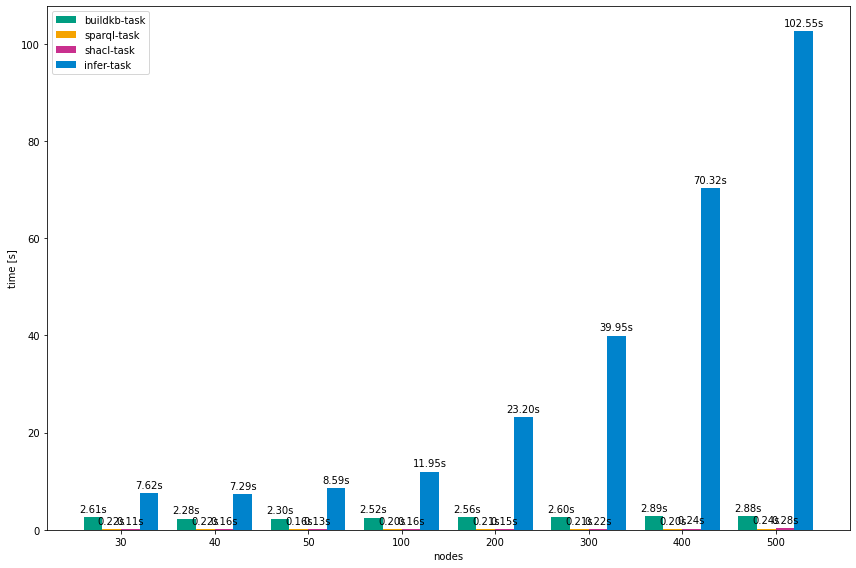

In [4]:
plotTaskTimeComparison(lowStore_times, ymin=None, ymax=None, fileBaseName="doublylinked_low_times")

<AxesSubplot:>

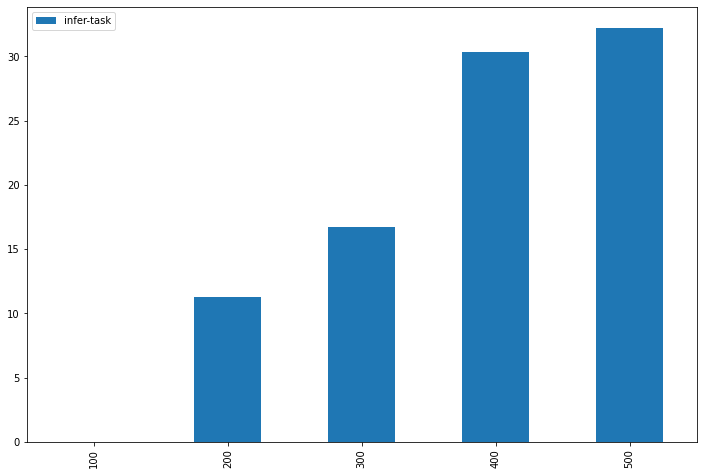

In [33]:
infer_frame = pd.DataFrame(
    lowStore_times['times'].loc[100:].apply(lambda x: x['infer'].total_seconds()),
)
infer_frame.columns=['infer-task']
infer_frame.diff().plot.bar()

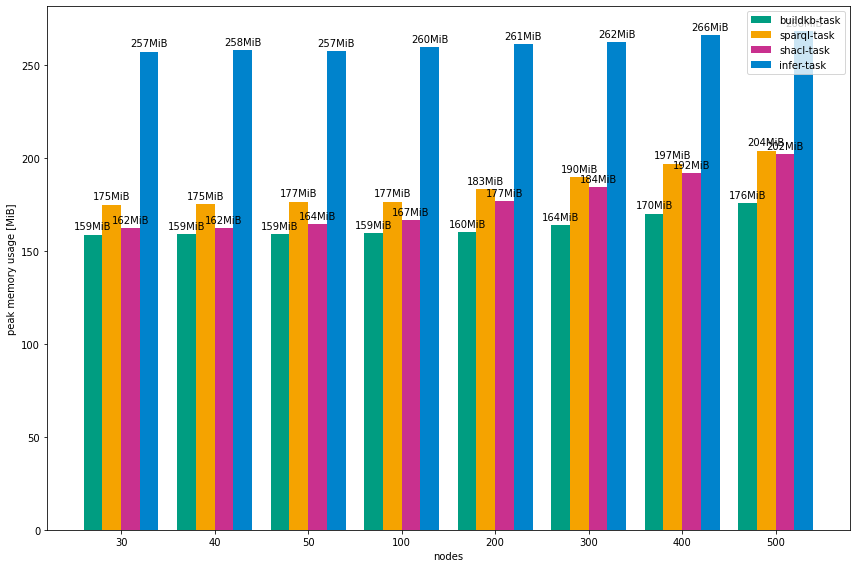

In [14]:
plotTaskMemoryComparison(lowStore_memory, ymin=None, ymax=None, fileBaseName="doublelinked_low_memory")

# High Store

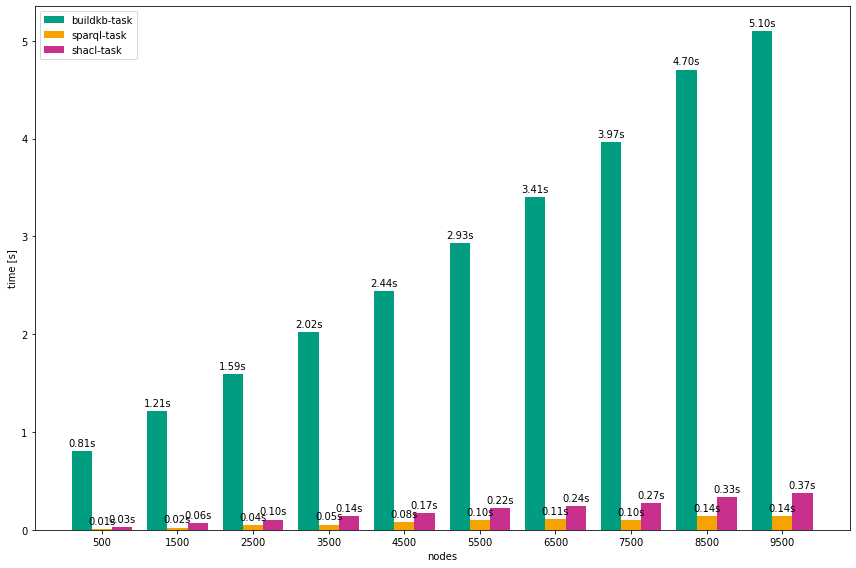

In [11]:
plotTaskTimeComparison(highStore_times, ymin=None, ymax=None, fileBaseName="doublylinked_high_times")

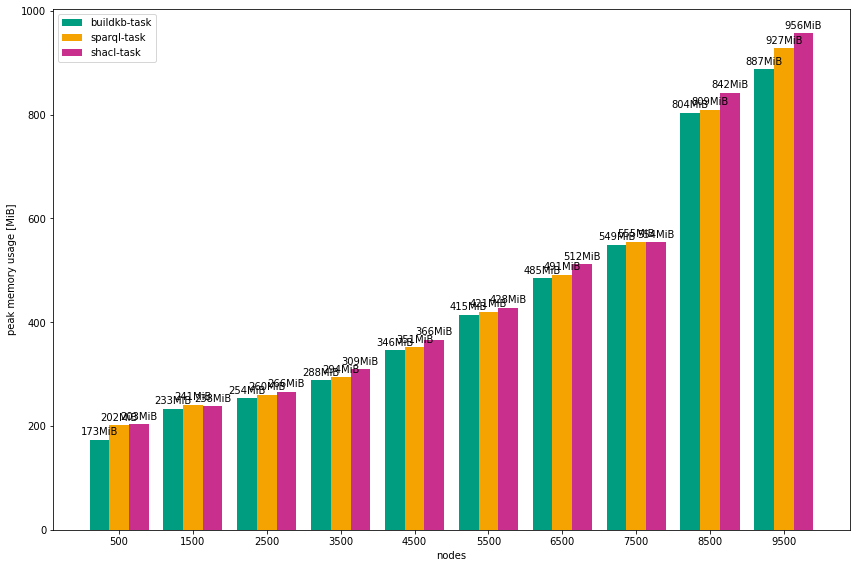

In [35]:
plotTaskMemoryComparison(highStore_memory, ymin=None, ymax=None, fileBaseName="doublylinked_high_memory")